Paper: https://arxiv.org/abs/1706.03762

Reference video: https://www.youtube.com/watch?v=U0s0f995w14

Reference blog: http://peterbloem.nl/blog/transformers


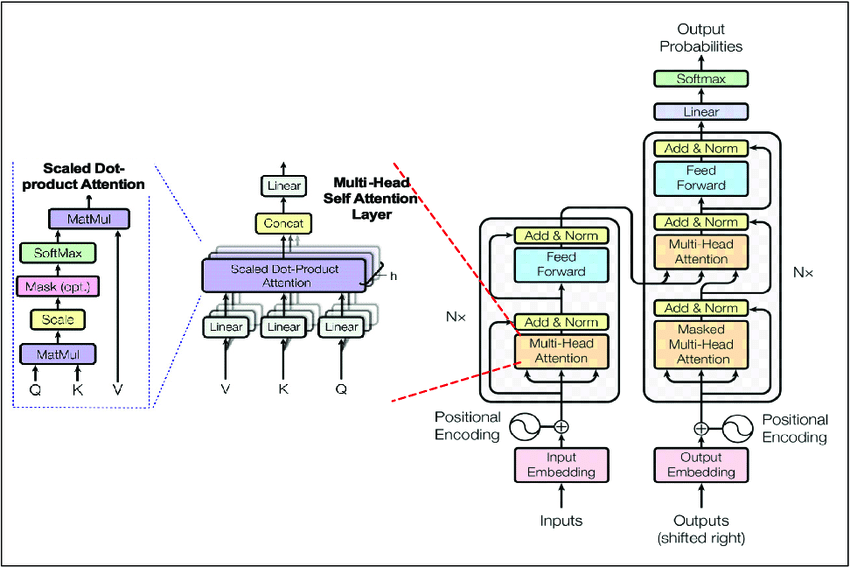

In [1]:
import torch

import torch.nn as nn

### Attention
<div>
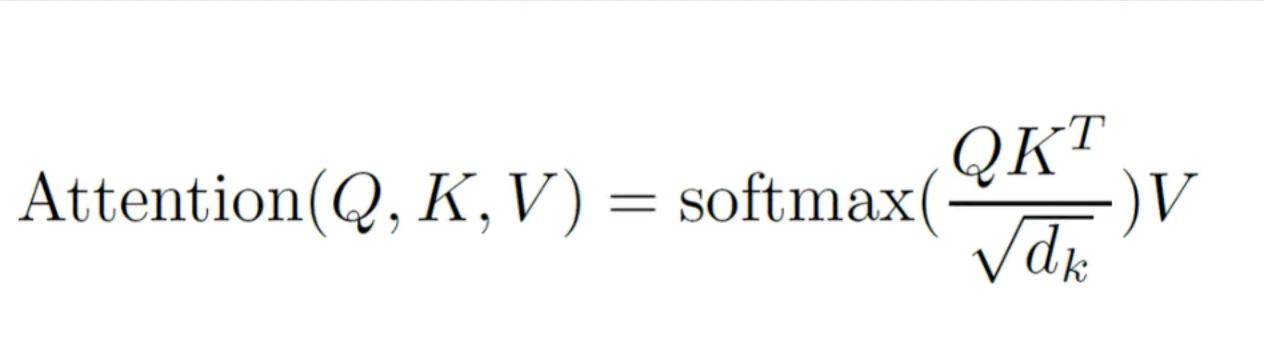
</div>

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size: int, heads: int):
        """
        embed_size : input embedding size
        heads : number of splits needed on the input embedding of embed_size 
        """
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert self.head_dim * heads == embed_size, "'embed_size' should be divisible by 'heads'"
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)
        
    def forward(self, values, keys, queries, mask):
        """
        key -> source sentence
        query -> target sentence
        """
        # batch size - number of examples
        N = queries.shape[0]
        # dimensions of k, v and q
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]
        
        # splitting the k, v, q into self.heads number of vectors for multi head
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        
        values = self.values(values)
        keys = self.values(keys)
        queries = self.queries(queries)
        
        
        # specific matrix multiplication using einsum to get required dimensional result
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        # query_shape = (N, query_len, heads, head_dim)
        # key_shape = (N, key_len, heads, head_dim)
        # energy_shape = (N, heads, query_len, key_len)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
            
        # We have all needed for attention
        # calculate attention based on the formula in the above cell
        attention = torch.softmax(energy / self.embed_size ** (0.5), dim=3)
        # dim=3 -> softmax is calculated across 3rd dim, ie, key_len (eg: source sentence)
        
        
        # attention_shape = (N, heads, query_len, key_len)
        # energy_shape = (N, heads, query_len, key_len)
        # values_shape = (N, value_len, heads, head_dim)
        # out_shape = (N, query_len, heads, head_dim) then flatten last 2 dims (concat)
        # key_len will be equal to value_len := l
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        # The reshape at the end does the concatenation
        out = self.fc_out(out)
        return out

### Transformer Block
<div>
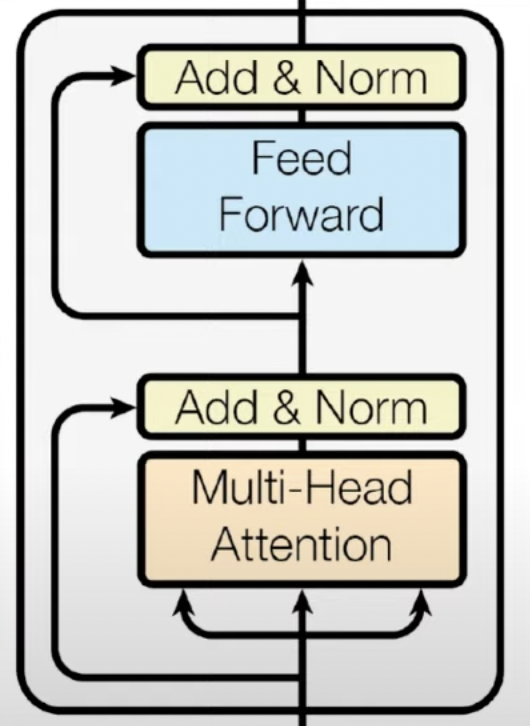
</div>

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)        
        
        self.feed_forward = nn.Sequential(
                nn.Linear(embed_size, forward_expansion*heads),
                nn.ReLU(),
                nn.Linear(forward_expansion*heads, embed_size)
                )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # add and norm
        # + query -> the skip connection
        x = self.norm1(attention + query)
        x = self.dropout(x)
        
        # feed forward
        forward = self.feed_forward(x)
        
        # + x -> the skip connection
        out = self.norm2(forward + x)
        return out
    

### Encoder
<div>
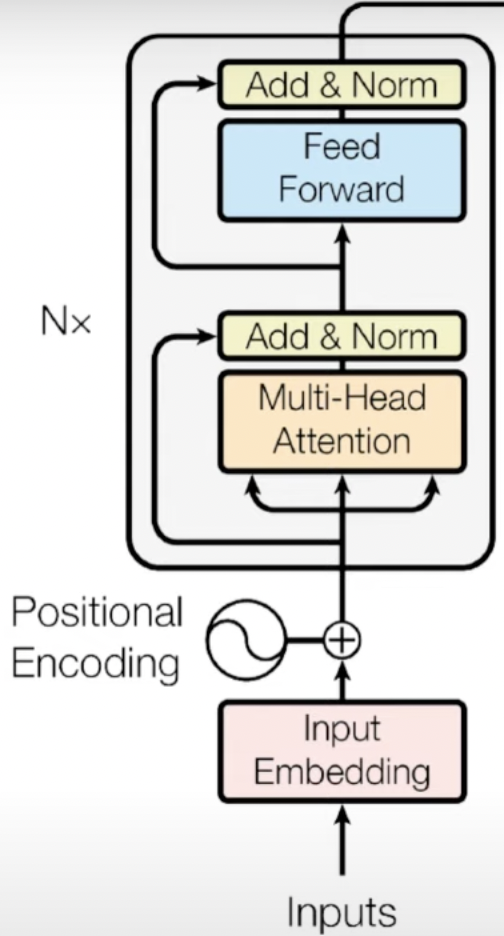
</div>

In [4]:
class Encoder(nn.Module):
    def __init__(self, 
                 src_vocab_size, 
                 embed_size, 
                 num_layers,
                 heads, 
                 device, 
                 forward_expansion, 
                 dropout,
                 max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
        [
            TransformerBlock(embed_size,
                             heads,
                             dropout,
                             forward_expansion
                            ) for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # x is a batch of input sequences
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out
    


### Decoder Block
<div>
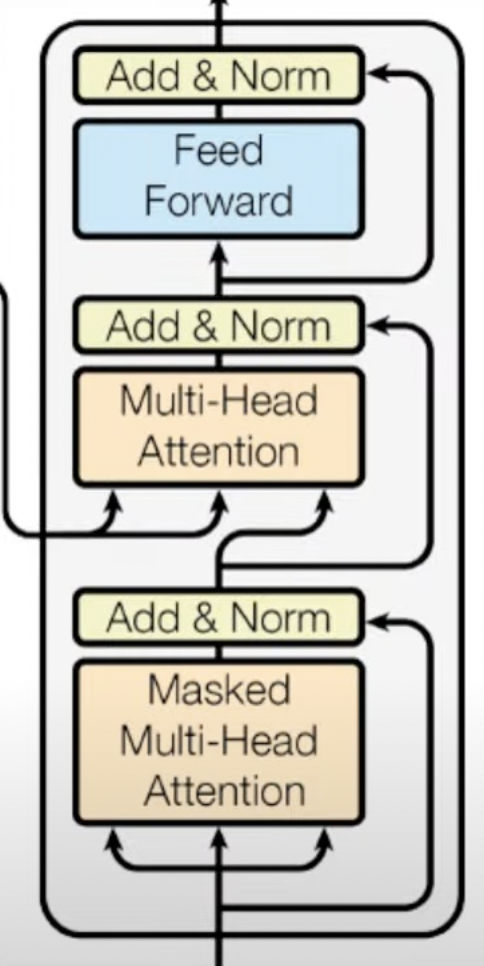
</div>

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out
        
        

### Decoder
<div>
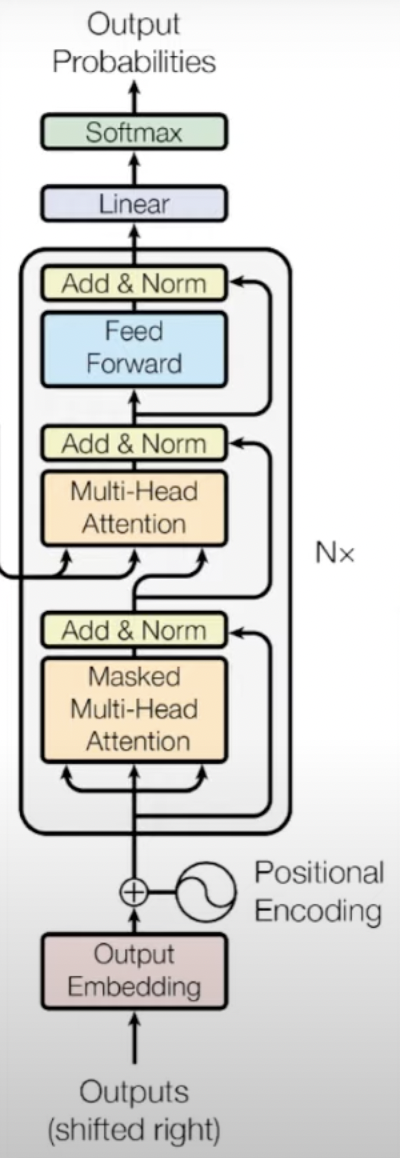
</div>

In [6]:
class Decoder(nn.Module):
    def __init__(self, 
                trg_vocab_size, 
                embed_size, 
                num_layers, 
                heads, 
                forward_expansion, 
                dropout, 
                device, 
                max_length):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device) for _ in range(num_layers)
            ]
        )
        
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        out = self.fc_out(x)
        
        return out
    
        
        

In [7]:
class Transformer(nn.Module):
    def __init__(self, 
                src_vocab_size,
                trg_vocab_size,
                src_pad_idx,
                trg_pad_idx,
                embed_size=256,
                num_layers=6,
                forward_expansion=4, 
                heads=8,
                dropout=0,
                device="cpu",
                max_length=100):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(src_vocab_size,
                               embed_size,
                               num_layers,
                               heads,
                               device,
                               forward_expansion,
                               dropout,
                               max_length,)
        
        self.decoder = Decoder(trg_vocab_size,
                                embed_size,
                                num_layers,
                                heads,
                                forward_expansion,
                                dropout,
                                device,
                                max_length,)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # dim will be (N, 1, 1, src_len)
        
        return src_mask.to(self.device)
    
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones(trg_len, trg_len)).expand(N, 1, trg_len, trg_len)
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_src_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        
        return out

In [14]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("using device: ", device)

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
        device
    )
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
        device
    )
    out = model(x, trg) # [:, :-1])
    print(out.shape)

using device:  cpu
torch.Size([2, 8, 10])


In [16]:
print(trg)
print(out)

tensor([[1, 7, 4, 3, 5, 9, 2, 0],
        [1, 5, 6, 2, 4, 7, 6, 2]])
tensor([[[ 0.2570, -0.0745, -0.0522,  0.5720, -0.1558,  0.8509, -1.0894,
           0.0659,  0.1668, -1.3494],
         [ 0.4060,  0.2810,  0.0030,  0.6245,  0.5572,  1.8002, -0.9025,
          -0.3743,  0.5828, -0.8572],
         [ 0.6747,  0.5417, -0.1578,  0.7256, -1.0009,  1.2718, -0.9992,
          -0.1945,  0.5166, -0.4903],
         [ 0.2378, -0.0474,  0.2469,  0.4644,  0.4162,  0.2601, -0.0961,
          -0.0970, -0.2231, -1.2369],
         [ 0.8886,  0.1797, -0.6461, -0.2252, -0.6876,  1.6294, -0.2974,
          -0.3888, -0.2966, -1.0798],
         [-0.1829, -0.0543,  0.6578,  0.8968,  0.4060,  0.4635, -0.1876,
          -0.0725,  0.7924,  0.0269],
         [ 0.3112,  0.8661,  0.2874,  0.4669, -0.0238,  0.8861, -0.7612,
          -0.1801,  0.5992, -0.8980],
         [ 0.5478,  0.1540,  0.1193,  1.0149,  0.6681,  0.5163, -0.0284,
           0.8473,  1.1824, -0.1831]],

        [[ 0.2905,  0.0595, -0.0777,  0.6

In [13]:
trg[:, :-1]

tensor([[1, 7, 4, 3, 5, 9, 2],
        [1, 5, 6, 2, 4, 7, 6]])